# 2.05: Blood Glucose Analysis
This notebook is used to analyse the blood glucose data from the patients. The intention is to understand blood glucose patterns and how they relate to changes in the insulin on board (IOB) and carbohydrates on board (COB). The analysis will focus on the following:
1. **Variability**: How much the blood glucose levels vary between nights, between individuals and for an individual.
2. **Rate of Change**: How quickly the blood glucose levels change over time.
3. **Peaks**: How often the blood glucose levels peak above a certain threshold for certain periods of the night.
4. **Correlation**: How the blood glucose levels correlate with the IOB and COB levels.
Lets start by loading the data and extracting aggregated data around variability for individuals.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.configurations import Configuration
from src.data_processing.read_preprocessed_df import ReadPreprocessedDataFrame
from src.data_processing.read import read_profile_offsets_csv
from src.helper import separate_flat_file
from src.candidate_selection import remove_null_variable_individuals, \
    provide_data_statistics
from datetime import time
from src.data_processing.read_preprocessed_df import apply_and_filter_by_offsets
from src.time_series_analysis import return_count_intervals
from src.configurations import ThirtyMinute
from src.nights import Nights
from src.bg_analysis import BGAnalyser

2025-06-24 21:36:55.716 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [2]:
config = Configuration()

df_new_30 = ReadPreprocessedDataFrame(ThirtyMinute(), file_type='parquet').df
df_offsets = read_profile_offsets_csv(config)
night_start = time(17, 0)
morning_end = time(11, 0)
sample_rate = 30
count_of_intervals = return_count_intervals(night_start, morning_end, minute_interval=sample_rate)
df_processed = apply_and_filter_by_offsets(offsets_df=df_offsets,
                                           interim_df=df_new_30)
df_processed = remove_null_variable_individuals(df_processed)
separated = separate_flat_file(df_processed)
df_overall_stats = provide_data_statistics(separated, sample_rate=sample_rate, night_start=night_start, morning_end=morning_end)


2025-06-24 21:37:12.996 | INFO     | src.data_processing.read_preprocessed_df:apply_and_filter_by_offsets:101 - IDs missing in offsets_df: {98974339, 35533061, 78420229, 66019205, 68026248, 40997757, 32997134, 1352464, 17161370, 49551394, 37998755, 40237051, 25692073, 74077367, 14092221, 18991425, 35719805, 43589707, 897741, 66937570, 65143138, 60844515, 27819368, 56958831, 80796147, 40634871, 16975609, 20396154, 81099003, 28176124, 86286077}
2025-06-24 21:37:13.935 | INFO     | src.candidate_selection:remove_null_variable_individuals:32 - Following individuals have one or more variables missing: set()
No stats per night have been calculated for 67167655. Returning no output.


The following analysis is based on the constraint (at the point of analysis) that we're putting on 'usable' nights which is that they have only a single 30min interval missing, or are complete, and a candidate must have 30 nights or greater. If these constraints change, then the analysis will only serve to show the process.

In [3]:
df_overall_stats['useful_nights'] = df_overall_stats['complete_nights'] + df_overall_stats['single_interval_nights']
df_stats = df_overall_stats[['count_of_nights', 'useful_nights', 'bg_sd_median', 'bg_range_median', 'bg_iqr_median']]
df_stats = df_stats[df_stats['useful_nights'] >= 30]
print(f'Total number of individuals with 30 or more useful nights: {len(df_stats)}')
print(f'Total number of nights across these individuals: {df_stats["useful_nights"].sum()}')

Total number of individuals with 30 or more useful nights: 17
Total number of nights across these individuals: 965


We'll now look at the variability of the blood glucose levels across the nights for each individual. The variability is measured by the standard deviation, range and interquartile range (IQR) of the blood glucose levels. This is across all 'useful' nights, i.e. defined as either complete nights or nights with a single 30min interval missing. The median of these values is used to represent the variability for each individual. The median is used to reduce the impact of outliers on the variability measure.

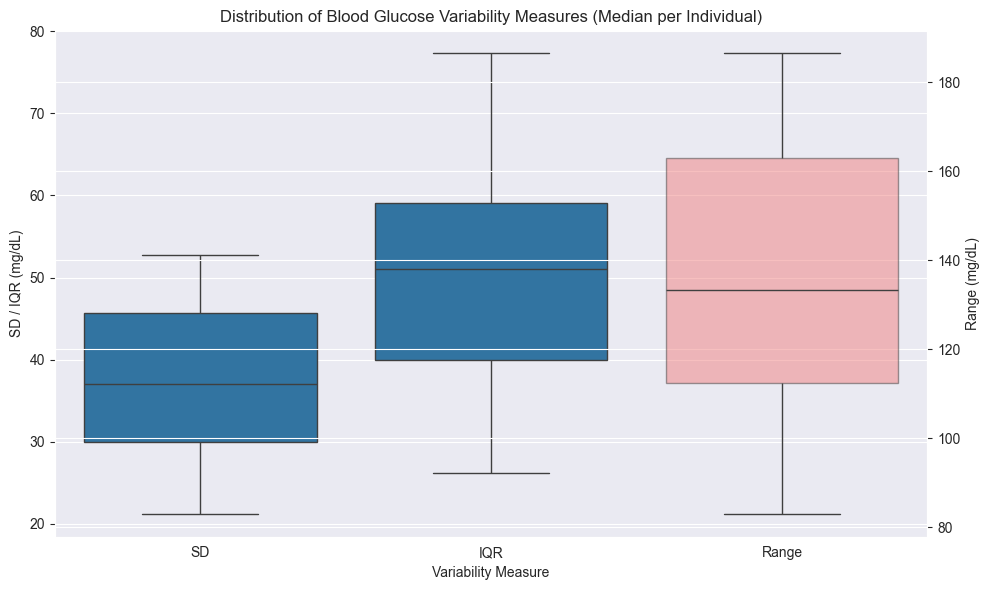

In [4]:
def plot_bg_variability(df_stats):
    """
    Plot the blood glucose variability measures (SD, IQR, Range) for each individual.
    :param df_stats: (DataFrame) DataFrame containing the blood glucose variability statistics.
    """
    melted = df_stats.melt(value_vars=['bg_sd_median', 'bg_range_median', 'bg_iqr_median'],
                           var_name='Variability Measure', value_name='Value')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Boxplot for bg_sd_median and bg_iqr_median on ax1
    sns.boxplot(x='Variability Measure', y='Value', data=melted[melted['Variability Measure'].isin(['bg_sd_median', 'bg_iqr_median'])], ax=ax1)
    ax1.set_ylabel('SD / IQR (mg/dL)')
    ax1.set_xlabel('Variability Measure')
    ax1.set_title('Distribution of Blood Glucose Variability Measures (Median per Individual)')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    # Boxplot for bg_range_median on ax2
    sns.boxplot(x='Variability Measure', y='Value', data=melted[melted['Variability Measure']=='bg_range_median'], ax=ax2, boxprops=dict(facecolor='lightcoral', alpha=0.5))
    ax2.set_ylabel('Range (mg/dL)')

    # Adjust x-tick labels to show all three categories
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels(['SD', 'IQR', 'Range'])
    plt.tight_layout()
    plt.show()

plot_bg_variability(df_stats)

In [10]:
# Skew and kurtosis of the distributions
from scipy.stats import skew, kurtosis
cols = ['bg_sd_median', 'bg_range_median', 'bg_iqr_median']
def calculate_skew_kurtosis(df: pd.DataFrame, variables: list = None) -> pd.DataFrame:
    """
    Calculate skewness and kurtosis for the variables included.
    :param df: (DataFrame) DataFrame containing the variables.
    :param variables: (list) List of variables to calculate skewness and kurtosis for.
    :return: (DataFrame) DataFrame with skewness and kurtosis values.
    """
    skewness = df[variables].apply(skew)
    kurt = df[variables].apply(kurtosis)

    return pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt})

calculate_skew_kurtosis(df_stats, cols)

,Skewness,Kurtosis
bg_sd_median,0.354790,-0.589486
bg_range_median,0.182933,-0.356620
bg_iqr_median,0.450384,-0.550974


All negative valuess for kurtosis indicate that the distributions are platykurtic, meaning they have lighter tails than a normal distribution. The skewness values are all close to zero, indicating that the distributions are fairly symmetric. This suggests that the variability measures are not heavily influenced by extreme values and are relatively consistent across individuals.

Note that this is across the whole timeframe of the period. This will take into account the last meal and BG spike following this. If we limit the hours to between 22:00 and 06:00, this will focus better on the variability during the sleep period, even though the times are arbitrary and do not take into account the individual sleep patterns or chronotype. Lets look at this data and distribution.


In [6]:
night_start = time(22, 0)
morning_end = time(6, 0)

df_overall_stats = provide_data_statistics(separated, sample_rate=sample_rate, night_start=night_start, morning_end=morning_end)

No stats per night have been calculated for 15634563. Returning no output.
No stats per night have been calculated for 49796612. Returning no output.
No stats per night have been calculated for 67167655. Returning no output.


In [11]:
print('Single interval missing constraint applied, i.e. complete nights and single interval missing')
df_overall_stats['useful_nights'] = df_overall_stats['complete_nights'] + df_overall_stats['single_interval_nights']
df_stats = df_overall_stats[['count_of_nights', 'useful_nights']+cols]
df_stats = df_stats[df_stats['useful_nights'] >= 30]
print(f'Total number of individuals with 30 or more useful nights: {len(df_stats)}')
print(f'Total number of nights across these individuals: {df_stats["useful_nights"].sum()}')

Single interval missing constraint applied, i.e. complete nights and single interval missing
Total number of individuals with 30 or more useful nights: 40
Total number of nights across these individuals: 3087


In [8]:
print('\nComplete nights constraint applied, i.e. not single interval missing')
df_stats = df_overall_stats[['count_of_nights', 'complete_nights']+cols]
df_stats = df_stats[df_stats['complete_nights'] >= 30]
print(f'Total number of individuals with 30 or more useful nights: {len(df_stats)}')
print(f'Total number of nights across these individuals: {df_stats["complete_nights"].sum()}')


Complete nights constraint applied, i.e. not single interval missing
Total number of individuals with 30 or more useful nights: 28
Total number of nights across these individuals: 1795


Without limiting to the existing candidates - i.e. using only the constaint of 30 or more nights and allowing for a single_interval_missed as well as complete nights - we can see that the number of individuals and nights and periods is much higher. This is because the constraints of the candidates are not applied, so we can see the variability across all individuals. If we do the same but limiting to complete nights...

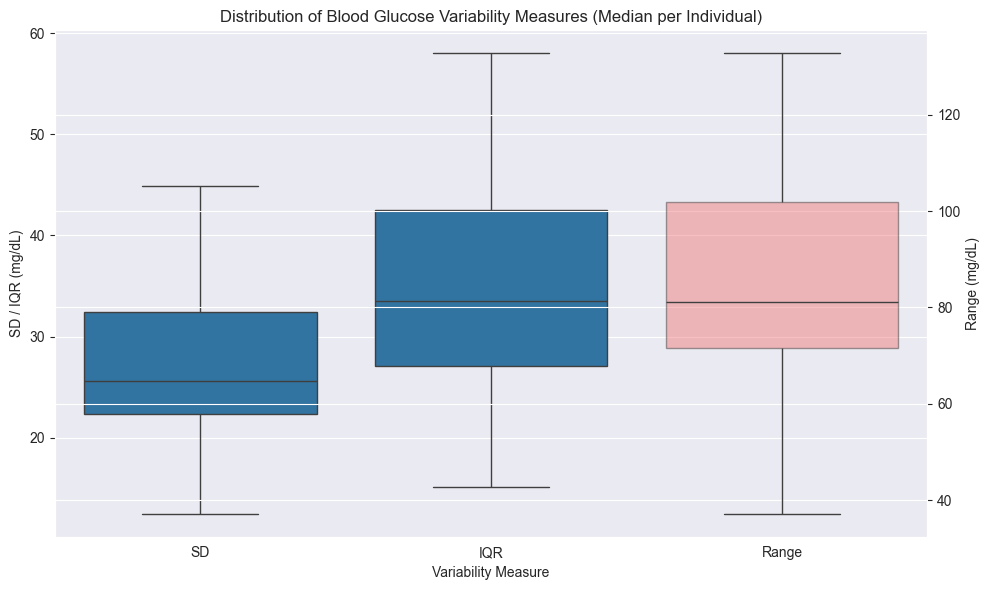

,Skewness,Kurtosis
bg_sd_median,0.454197,-0.148656
bg_range_median,0.349992,-0.046687
bg_iqr_median,0.408826,-0.237742


In [12]:
plot_bg_variability(df_stats)
calculate_skew_kurtosis(df_stats, cols)

These show more skew to the lower to the minimal values, with the IQR and SD being more platykurtic. The range is more normal, but still has a slight skew to the lower values. This suggests that the variability measures are more consistent over this more bound time period. The variance is more muted than the 17:00-11:00 period as expected, given the lack of meals and the more stable blood glucose levels during the night. We now want to take a different perspective on the variability, considering how we might identify groups of nights that appear anomalous for an individual. To do this, we will use the z-score to identify nights that are more than 2 standard deviations away from the mean for an individual. This will help us identify nights that are significantly different from the individual's normal blood glucose patterns. The z-score allows us to standardise the blood glucose levels for each individual, making it easier to compare nights across individuals. We will then plot the z-scores for each individual and possibly compare them to other individuals with different distributions, to see if there are any patterns or similarities in the blood glucose levels across them. The z-score is calculated as follows:
$$ z = \frac{(x - \mu)}{\sigma} $$

where:
- \( x \) is the blood glucose level for a specific night
- \( \mu \) is the mean blood glucose level for the individual
- \( \sigma \) is the standard deviation of the blood glucose levels for the individual
- \( z \) is the z-score for the blood glucose level
